# Прогнозирование оттока клиентов сети фитнес-клубов

## Описание проекта

### Данные:
- данные о посетителях сети фитнес-центров на основе журнала посещений, покупок на месяц до оттока и факт оттока на определенный месяц.

### Цели и задачи:
Необходимо провести анализ поведения клиентов, спрогнозировать вероятность оттока и разработать меры по удержанию клиентов.

### <a id="content">Содержание:</a>
1. [Подготовка данных](#preparation)
2. [Исследовательский анализ данных (EDA)](#EDA)
3. [Модель прогнозирования оттока](#model)
4. [Кластеризация клиентов](#cluster)
5. [Выводы и рекомендации](#conclusion)

## <a id="preparation">1. Подготовка данных</a>
[Вернуться к оглавлению](#content)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('C:/Users/liana/datasets/gym_churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [3]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
#приводим названия столбцов к одному регистру
data.columns = data.columns.str.lower()

In [5]:
#проверяем на наоичие дубликатов
data[data.duplicated()]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn


In [6]:
#првоеряем на наличие пропусков
data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Выводы:

Пропусков нет, дубликатов нет, типы данных в порядке.

## <a id="EDA">2. Исследовательский анализ данных (EDA)</a>
[Вернуться к оглавлению](#content)

In [7]:
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [9]:
#средние значения признаков в группах, кто ушел в отток и кто остался
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


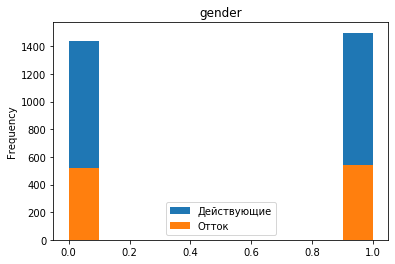

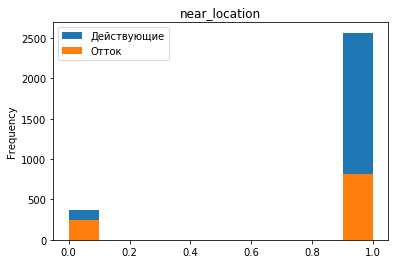

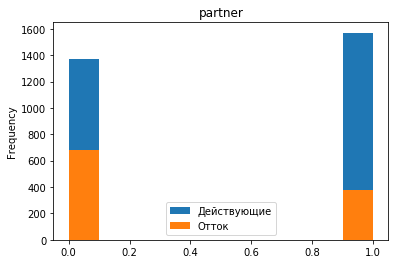

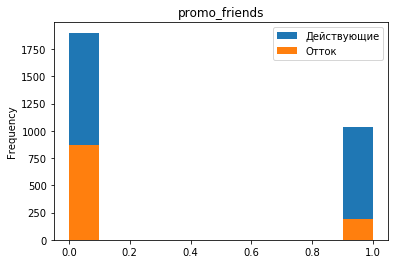

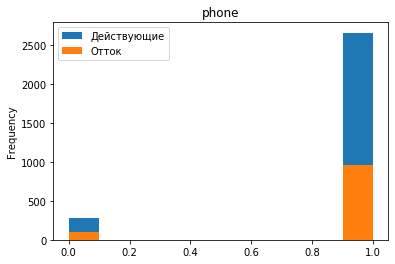

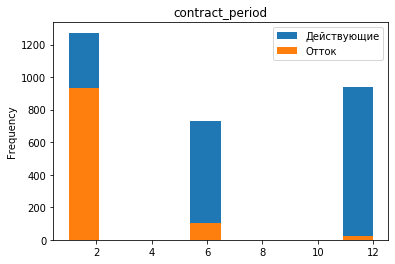

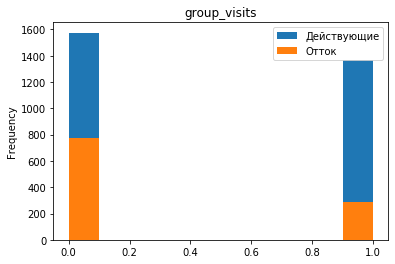

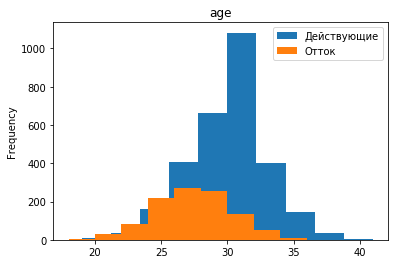

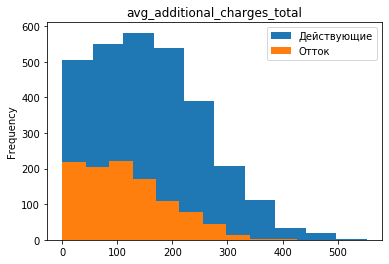

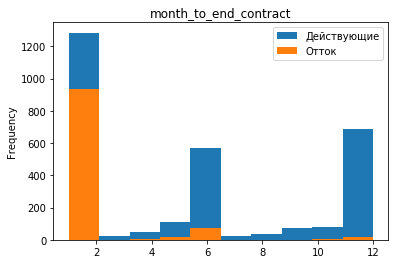

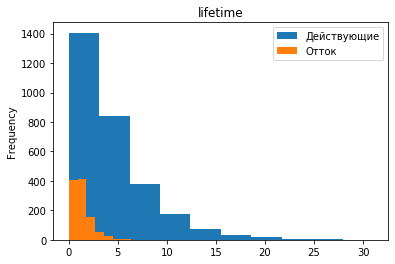

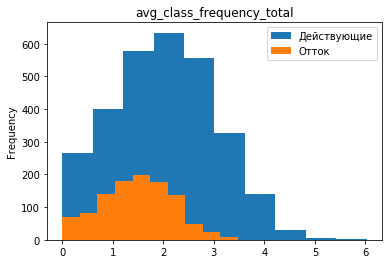

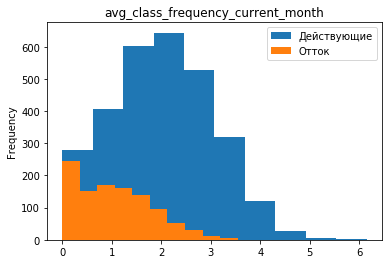

In [10]:
#строим распрделения признаков для групп оттока и действующих клиентов
for i in data.drop('churn', axis = 1).columns:
    data.groupby('churn')[i].plot(kind = 'hist', title = i, legend = True)
    plt.legend(['Действующие', 'Отток'])
    plt.show()

In [11]:
#считаем корреляции
cm = data.corr()

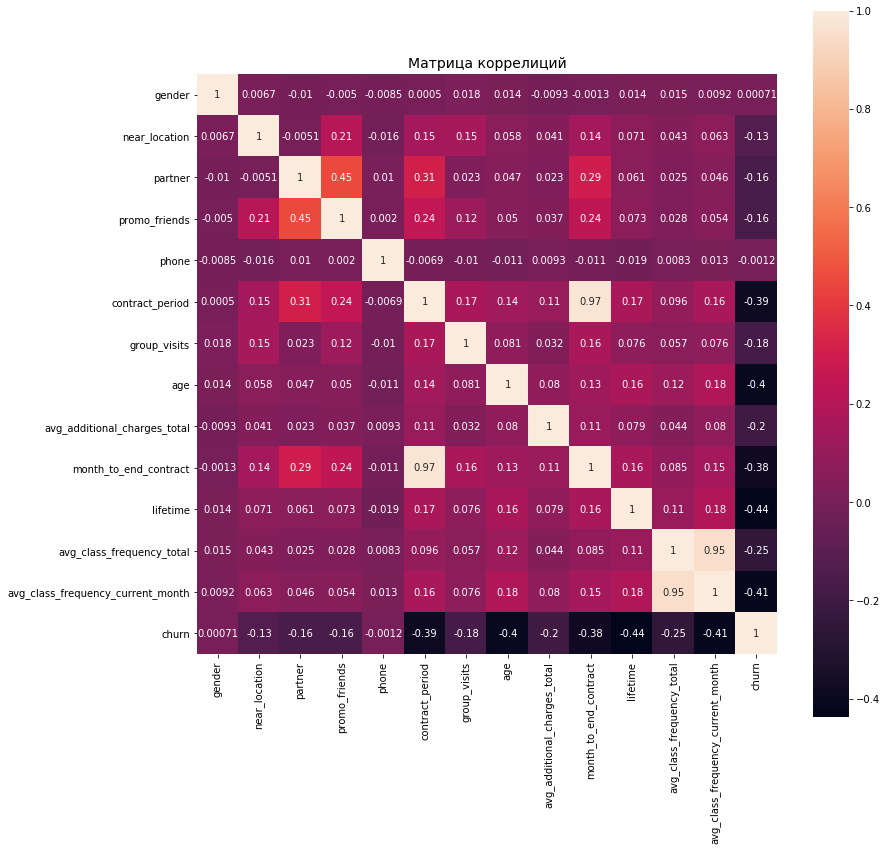

In [12]:
#строим матрицу корреляций
plt.figure(figsize = (13, 13))
plt.title('Матрица коррелиций', fontsize = 14)
sns.heatmap(cm, annot = True, square = True)
plt.show()

Вывод:

Половых различий между действующими клиентами и теми, кто в оттоке, нет. Также не повлияло наличие/отсутствие номера телефона клиента. Средний возраст составляет 29 лет для действующих клиентов и 26 для тех, кто в оттоке.
Среди тех, кто живет далеко, доля оттока больше, чем среди тех, кто живет близко.
Среди сотрудников компаний-партнеров и среди тех, кто пришел по акции "Приведи друга", отток меньше.
Среди тех, кто посещает групповые занятия, доля оттока меньше.
Больший отток среди тех, у кого длительность абонемента составляет месяц или у кого остался месяц до конца абонемента.
Частота посещений действующих клиентов выше, чем тех, кто в оттоке.

Корреляция выявлена между длительностью абонемента и тем, сколько осталось до конца действия абонемента, и между частотой посещения за последний месяц и за все время.

## <a id="model">3. Модель прогнозирования оттока</a>
[Вернуться к оглавлению](#content)

In [13]:
#удаляем столбцы с большой корреляцией
data = data.drop(['avg_class_frequency_total', 'contract_period'], axis = 1)

In [14]:
#выделим целевую переменную и признаки
X = data.drop('churn', axis = 1)
y = data['churn']

In [15]:
#поделим на обучающую и валидационную части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [16]:
#модели для цикла
models = [LogisticRegression(), RandomForestClassifier()]

In [17]:
#обучаем модель и считаем метрики
for i in models:
    print(i)
    model = i
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print('accuracy:{:.2f}'.format(accuracy_score(y_test, predictions)))
    print('precision:{:.2f}'.format(precision_score(y_test, predictions)))
    print('recall:{:.2f}'.format(recall_score(y_test, predictions)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy:0.90
precision:0.79
recall:0.80
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


C:\Users\liana\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy:0.89
precision:0.80
recall:0.74


In [18]:
data[data['churn'] == 0]['churn'].count()

2939

Выводы:

Доля правильных ответов (accuracy) выше у логистической регрессии, но так как соотношение между действующими клиентами и "оттоком" составляет ~1/3, а не 1/1, то смотрим по остальным метрикам. По точности (preccision) и полноте (recall) тоже лучше логистическая регрессия.

## <a id="cluster">4. Кластеризация клиентов</a>
[Вернуться к оглавлению](#content)

In [19]:
#стандартизация данных
scaler = StandardScaler()
X_st = scaler.fit_transform(X) 

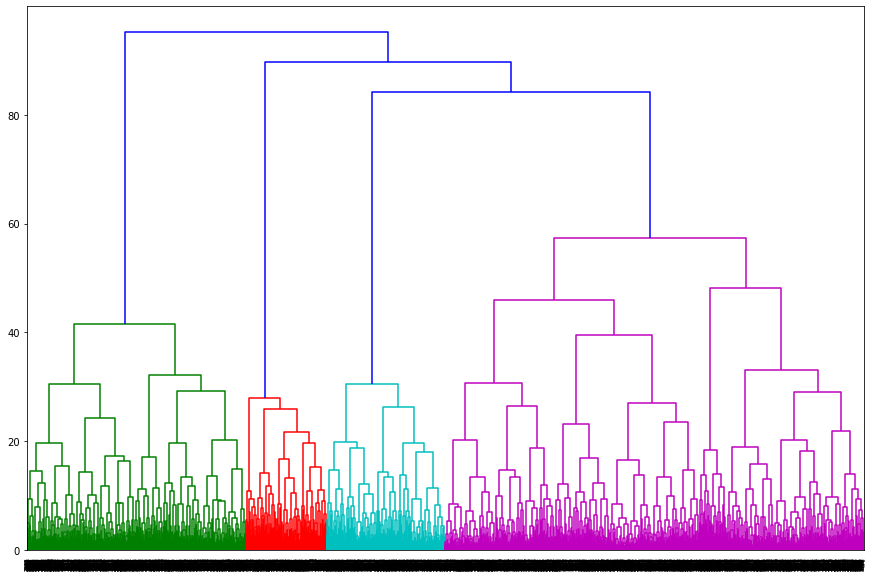

In [20]:
#строим матрицу расстояний и рисуем дендрограмму
linked = linkage(X_st, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

In [21]:
#обучаем модель кластеризации
km = KMeans(n_clusters = 5)
labels = km.fit_predict(X_st)

In [22]:
#добавляем деление на кластеры в датафрейм
data['labels'] = labels

In [23]:
#средние значения признаков по кластерам
data.groupby('labels').mean().T

labels,0,1,2,3,4
gender,0.482966,0.493671,0.553407,0.523316,0.494371
near_location,0.584168,0.882459,0.951197,0.862694,0.966223
partner,0.355711,0.649186,0.132597,0.471503,0.928352
promo_friends,0.060120,0.000000,0.072744,0.305699,1.000000
phone,1.000000,1.000000,1.000000,0.000000,1.000000
group_visits,0.150301,0.481013,0.520258,0.427461,0.514841
age,27.131263,30.032550,30.290055,29.297927,29.527124
avg_additional_charges_total,113.763716,165.801264,163.427847,144.208179,152.920803
month_to_end_contract,1.716433,9.757685,1.955801,4.466321,6.483112
lifetime,1.757515,4.737794,4.472376,3.940415,4.244626


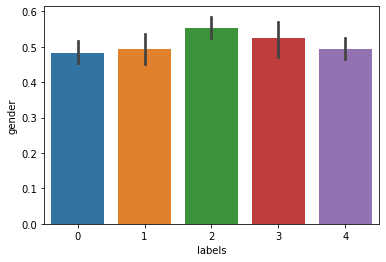

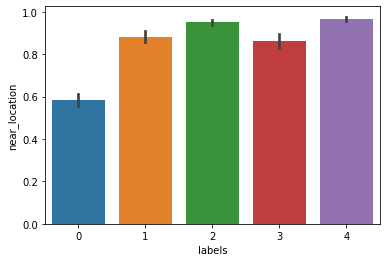

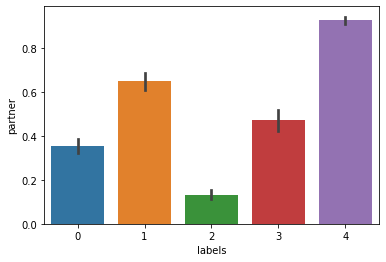

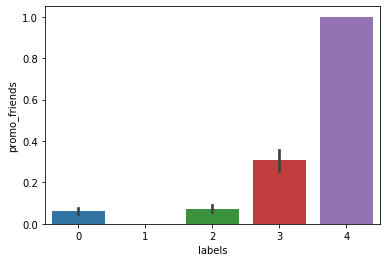

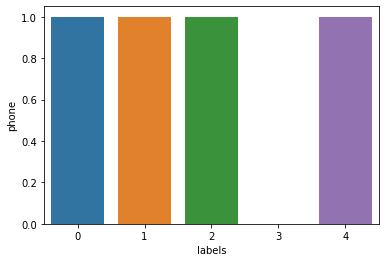

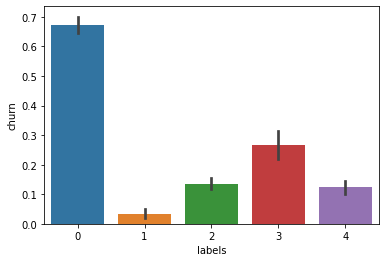

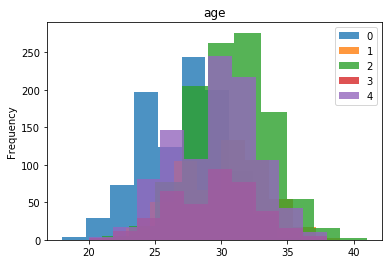

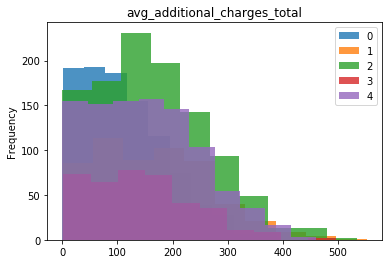

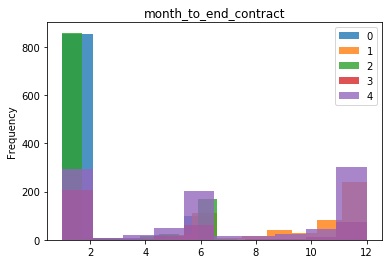

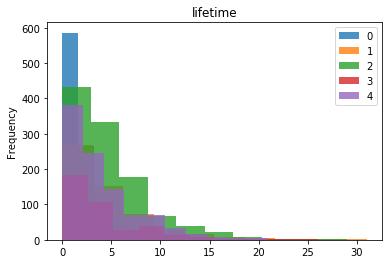

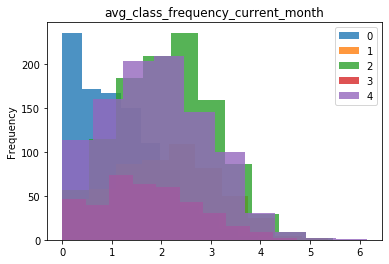

In [24]:
#Строим графики
for i in data.columns[0:5]:
    sns.barplot(x = data['labels'], y = data[i])
    plt.show()
sns.barplot(x = data['labels'], y = data['churn'])
plt.show()

for i in data.drop('labels', axis = 1).columns[6:11]:
    data.groupby('labels')[i].plot(kind = 'hist', title = i, legend = True, alpha = 0.8)
    plt.show()

In [25]:
#считаем долю оттока по кластерам
data.groupby('labels')['churn'].sum() / data.groupby('labels')['churn'].count() * 100 

labels
0    67.334669
1     3.254973
2    13.627993
3    26.683938
4    12.282497
Name: churn, dtype: float64

Выводы:

По дендрограмме получилось 4 кластера.
На таблице средних значений кластеров несколько отличается время, оставшееся до конца абонемента, и коэффициент оттока. На графиках разница между временем, оставшимся до конца абонемента, для разных кластеров не выявлена. 
Нулевой кластер не имеет телефона, третий кластер не живет поблизости от фитнес-центра, в первом кластере больше всего клиентов по промо-акции и по партнерской программе, у второго меньше всего доля оттока (меньше 2%), а у четвертого - больше всего (57%).


## <a id="conclusion">5. Выводы и рекомендации</a>
[Вернуться к оглавлению](#content)

Выводы:

Средний возраст составляет 29 лет для действующих клиентов и 26 для тех, кто в оттоке. Среди тех, кто живет далеко, доля оттока больше, чем среди тех, кто живет близко. Среди сотрудников компаний-партнеров и среди тех, кто пришел по акции "Приведи друга", отток меньше. Среди тех, кто посещает групповые занятия, доля оттока меньше. Больший отток среди тех, у кого длительность абонемента составляет месяц или у кого остался месяц до конца абонемента. Частота посещений действующих клиентов выше, чем тех, кто в оттоке.

На графиках разница между временем, оставшимся до конца абонемента, для разных кластеров не выявлена. Нулевой кластер не имеет телефона, третий кластер не живет поблизости от фитнес-центра, в первом кластере больше всего клиентов по промо-акции и по партнерской программе, у второго меньше всего доля оттока, а у четвертого - больше всего.
Доля оттока по кластерам: 0 - 27%, 1 - 12%, 2 - 2%, 3 - 40%, 4 - 57%.

Рекомендации:

1. На групповых занятиях отток меньше, возможно, люди посещают их, чтобы пообщаться, приятно провести время, сменить обстановку и т.д. А остальные возможности абонемента не так нужны. Было бы неплохо сделать абонемент с возможностью выбора одного или нескольких видов групповых занятий по более низкой по сравнению с обычными цене.
2. Также у сотрудников компаний-партнеров и у людей, которые пришли по промо-акции, коэффициент оттока меньше. Следовательно, нужно больше корпоративных клиентов и больше промо-акций. 
3. Клиенты с абонементами на месяц "теряются" саще всего. Возможно какая-нибудь мотивирующая акция типа "Купи абонемент на месяц и получишь еще 2 в подарок, если будешь заниматься 3 раза в неделю" поможет сформировать у людей привычку заниматься плюс положительный эффект от подарка. 
4. Чем больше времени до конца абонемента, тем меньше отток. Следовательно чем больше срок абонемента, тем меньше должен стоить месяц занятий. Может быть, стоит писать сравнительную цену абонементов за месяц.